In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

E0000 00:00:1755345723.313074      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver('local')
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    print('die')

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1755345742.645577      10 service.cc:148] XLA service 0x568a7eb37710 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755345742.645615      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1755345742.645619      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1755345742.645622      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1755345742.645626      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1755345742.645628      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1755345742.645631      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1755345742.645634      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1755345742.645636      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [3]:
num_embeddings=256
embedding_dim=256

In [4]:
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.layers import Conv2D, Add

@register_keras_serializable(package="Custom")
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.f = Conv2D(self.filters // 8, kernel_size=1, padding='same')
        self.g = Conv2D(self.filters // 8, kernel_size=1, padding='same')
        self.h = Conv2D(self.filters, kernel_size=1, padding='same')
        super().build(input_shape)

    def call(self, x):
        f = self.f(x)  # (B, H, W, C//8)
        g = self.g(x)
        h = self.h(x)  # (B, H, W, C)

        shape_f = tf.shape(f)
        B, H, W = shape_f[0], shape_f[1], shape_f[2]

        f_flat = tf.reshape(f, [B, H * W, self.filters // 8])
        g_flat = tf.reshape(g, [B, H * W, self.filters // 8])
        h_flat = tf.reshape(h, [B, H * W, self.filters])

        beta = tf.nn.softmax(tf.matmul(f_flat, g_flat, transpose_b=True), axis=-1)  # (B, N, N)

        o = tf.matmul(beta, h_flat)  # (B, N, C)
        o = tf.reshape(o, [B, H, W, self.filters])

        return Add()([x, o])  # Residual connection

    def get_config(self):
        config = super().get_config()
        # If you have custom arguments in __init__, add them here
        return config


In [5]:
captions = np.load('/kaggle/input/vqgan-parts/vqgan_epoch_90/Captions.npy')
tokens_seq = np.load('/kaggle/input/vqgan-parts/vqgan_epoch_90/Tokens_seq.npy').astype(np.int32)
encoder = tf.keras.models.load_model('/kaggle/input/vqgan-parts/vqgan_epoch_90/epoch_90_encoder.keras',custom_objects={'SelfAttention': SelfAttention})
decoder = tf.keras.models.load_model('/kaggle/input/vqgan-parts/vqgan_epoch_90/epoch_90_decoder.keras',custom_objects={'SelfAttention': SelfAttention})
codebook = np.load('/kaggle/input/vqgan-parts/vqgan_epoch_90/epoch_90_codebook.npy')

In [6]:
print(len(np.unique(tokens_seq)))

70


In [7]:
70/256

0.2734375

In [8]:
import string
import re

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 18500
sequence_length = 85

vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)


vectorizer.adapt(captions)
text_vect = tf.cast(vectorizer(captions),tf.int32)

In [9]:
start_tokens = tf.cast(tf.fill([len(text_vect), 1], 256),tf.int32)
decoder_tokens = tf.concat([start_tokens, tokens_seq], axis=1)

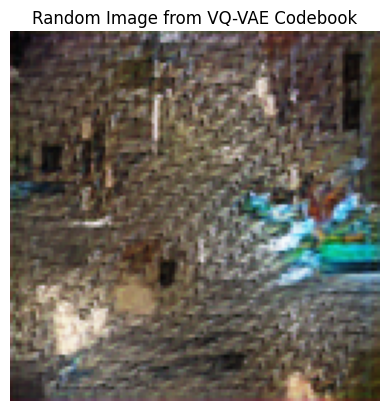

In [10]:
random_indices = tf.random.uniform(shape=(1, 16, 16), minval=100, maxval=254, dtype=tf.int32)
flat_indices = tf.reshape(random_indices, [-1])
quantized_vectors = tf.gather(codebook, flat_indices)
quantized_vectors = tf.reshape(quantized_vectors, (1, 16, 16
                                                   , embedding_dim))

# Decode to image
generated_image = decoder(quantized_vectors)
# Display
import matplotlib.pyplot as plt
plt.imshow(generated_image[0].numpy())
plt.axis('off')
plt.title('Random Image from VQ-VAE Codebook')
plt.show()

In [11]:
transformer_dataset = (
    tf.data.Dataset.from_tensor_slices((
        (tf.convert_to_tensor(text_vect, dtype=tf.int32),
         tf.convert_to_tensor(decoder_tokens[:, :-1], dtype=tf.int32)),
        tf.convert_to_tensor(decoder_tokens[:, 1:], dtype=tf.int32)
    ))
    .batch(512)
    .prefetch(tf.data.AUTOTUNE)
)

transformer_dataset = strategy.experimental_distribute_dataset(transformer_dataset)

In [12]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=int(embed_dim/num_heads))
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-5)
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-5)
        self.dropout_1 = layers.Dropout(0.1)

    def call(self, inputs, mask=None):
        # Convert mask to boolean with shape (batch, 1, seq_len)
        if mask is not None:
            mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.bool)

        attention_output = self.attention(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=mask
        )
        attention_output = self.dropout_1(attention_output)
        proj_input = self.layernorm_1(inputs + attention_output)

        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [13]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=int(embed_dim/num_heads))
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=int(embed_dim/num_heads))
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.dropout_1 = layers.Dropout(0.1)
        self.dropout_2 = layers.Dropout(0.1)
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-5)
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-5)
        self.layernorm_3 = layers.LayerNormalization(epsilon=1e-5)

    # def get_causal_attention_mask(self, inputs):
    #     seq_len = tf.shape(inputs)[1]
    #     causal_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len), dtype=tf.bool), -1, 0)
    #     return causal_mask[tf.newaxis, :, :]  # (1, seq_len, seq_len)

    def call(self, inputs, encoder_outputs, mask=None):
        # Padding mask: (batch_size, 1, seq_len)
        # if mask is not None:
        #     padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.bool)
        # else:
        #     padding_mask = None

        # # Causal mask: (1, seq_len, seq_len)
        # causal_mask = self.get_causal_attention_mask(inputs)

        # # Combine masks for self-attention
        # if padding_mask is not None:
        #     combined_mask = tf.logical_and(padding_mask, causal_mask)
        # else:
        #     combined_mask = causal_mask

        # Self-attention with combined mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            use_causal_mask=True
        )
        attention_output_1 = self.dropout_1(attention_output_1)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)

        # Cross-attention with padding mask only
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=mask,
            use_causal_mask=False
        )
        attention_output_2 = self.dropout_2(attention_output_2)
        attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)

        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [14]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, mask_zero = True, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim,mask_zero=mask_zero)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim,mask_zero=False)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

In [15]:
with strategy.scope():
    embed_dim = 256
    dense_dim = 1024
    num_heads = 8
    num_blocks = 10
    
    encoder_inputs = tf.keras.Input(shape=(None,), dtype="int32", name="encoder_inputs")
    decoder_inputs = tf.keras.Input(shape=(None,), dtype="int32", name="decoder_inputs")
    
    # Padding masks
    encoder_mask = tf.keras.layers.Lambda(lambda x: tf.cast(tf.not_equal(x, 0), tf.bool))(encoder_inputs)
    cross_attention_mask = tf.keras.layers.Lambda(lambda x: tf.cast(x[:, tf.newaxis, tf.newaxis, :], tf.bool))(encoder_mask) 
    
    # Embeddings
    encoder_embed = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
    decoder_embed = PositionalEmbedding(256, 257, embed_dim,mask_zero=False)(decoder_inputs)
    
    # Encoder blocks
    x = encoder_embed
    for _ in range(num_blocks):
        x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x, mask=encoder_mask)
    encoder_outputs = x
    
    # Decoder blocks
    x = decoder_embed
    for _ in range(num_blocks):
        x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs, mask=cross_attention_mask)
    
    # Final layers
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = layers.Dropout(0.1)(x)
    decoder_outputs = layers.Dense(256)(x)

    transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

I0000 00:00:1755345759.749270      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [16]:
transformer.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  4,757,760 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None)      │          0 │ encoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 256) │    789,760 │ positional_embed… │
│ (TransformerEncode… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │    789,760 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │    789,760 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │    789,760 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │    789,760 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │    789,760 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │    789,760 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │    789,760 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │    789,760 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │    131,328 │ decoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │    789,760 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1, 1,      │          0 │ lambda[0][0]      │
│                     │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decoder │ (None, None, 256) │  1,053,440 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco

 Total params: 23,387,392 (89.22 MB)

 Trainable params: 23,387,392 (89.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
with strategy.scope():
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    transformer.compile(loss=loss_fn,
                       optimizer=optimizer,
                       metrics=['accuracy'])
    transformer.fit(transformer_dataset,epochs=100)

Epoch 1/100


I0000 00:00:1755345819.166649      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:5748077125226189496
I0000 00:00:1755345829.733455     950 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5074540333524566785), session_name()
I0000 00:00:1755345919.488563     950 tpu_compile_op_common.cc:245] Compilation of 5074540333524566785 with session name  took 1m29.755062929s and succeeded
I0000 00:00:1755345919.787519     950 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5074540333524566785), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_5748077125226189496", property.function_library_fingerprint = 9123234235775572221, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().

310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.1203 - loss: 4.0252

I0000 00:00:1755345993.767605     953 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(17577636015319845081), session_name()
I0000 00:00:1755346079.433190     953 tpu_compile_op_common.cc:245] Compilation of 17577636015319845081 with session name  took 1m25.665547469s and succeeded
I0000 00:00:1755346079.718846     953 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(17577636015319845081), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_5748077125226189496", property.function_library_fingerprint = 9123234235775572221, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "25,85,;25,256,;25,256,;", property.guaranteed_constants_size = 0, em

311/311 ━━━━━━━━━━━━━━━━━━━━ 287s 518ms/step - accuracy: 0.1205 - loss: 4.0234
Epoch 2/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 77s 241ms/step - accuracy: 0.1678 - loss: 3.4776
Epoch 3/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 75s 238ms/step - accuracy: 0.1735 - loss: 3.4228
Epoch 4/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 75s 239ms/step - accuracy: 0.1774 - loss: 3.3917
Epoch 5/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 75s 239ms/step - accuracy: 0.1859 - loss: 3.3391
Epoch 6/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 76s 240ms/step - accuracy: 0.1966 - loss: 3.2603
Epoch 7/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 76s 242ms/step - accuracy: 0.2053 - loss: 3.2111
Epoch 8/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 75s 240ms/step - accuracy: 0.2104 - loss: 3.1803
Epoch 9/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 76s 241ms/step - accuracy: 0.2142 - loss: 3.1554
Epoch 10/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 75s 238ms/step - accuracy: 0.2174 - loss: 3.1344
Epoch 11/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 76s 240ms/step - accuracy: 0.2204 - loss: 3.1152
Epoch 12/100
311/31

In [ ]:
start_token = 256
max_output_length = 256

def generate_image_tokens(input_text):
    # Vectorize input text
    tokenized_text = vectorizer([input_text])  # Shape: (1, text_seq_len)

    # Start the decoded sequence with the start token
    decoded_image_tokens = [start_token]

    for i in range(max_output_length):
        # Convert to proper input format
        decoder_input = tf.convert_to_tensor([decoded_image_tokens])

        # Predict next token probabilities
        predictions = (transformer([tokenized_text, decoder_input]))
        

        # Get the token for the current step
        sampled_token_index = np.argmax(predictions[0, i, :])

        # Append token to sequence
        decoded_image_tokens.append(sampled_token_index)

    # Optionally decode tokens into an image here
    return decoded_image_tokens

# Example use
output_tokens = generate_image_tokens("A man wearing a red shirt in walking in the road")[1:]
print(np.shape(output_tokens))

In [ ]:
@register_keras_serializable(package="Custom")
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.f = Conv2D(self.filters // 8, kernel_size=1, padding='same')
        self.g = Conv2D(self.filters // 8, kernel_size=1, padding='same')
        self.h = Conv2D(self.filters, kernel_size=1, padding='same')
        super().build(input_shape)

    def call(self, x):
        f = self.f(x)  # (B, H, W, C//8)
        g = self.g(x)
        h = self.h(x)  # (B, H, W, C)

        shape_f = tf.shape(f)
        B, H, W = shape_f[0], shape_f[1], shape_f[2]

        f_flat = tf.reshape(f, [B, H * W, self.filters // 8])
        g_flat = tf.reshape(g, [B, H * W, self.filters // 8])
        h_flat = tf.reshape(h, [B, H * W, self.filters])

        beta = tf.nn.softmax(tf.matmul(f_flat, g_flat, transpose_b=True), axis=-1)  # (B, N, N)

        o = tf.matmul(beta, h_flat)  # (B, N, C)
        o = tf.reshape(o, [B, H, W, self.filters])

        return Add()([x, o])  # Residual connection

    def get_config(self):
        config = super().get_config()
        # If you have custom arguments in __init__, add them here
        return config



def get_embeddings(indices, codebook):
    flat_indices = tf.reshape(indices, [-1])
    flat_embeddings = tf.nn.embedding_lookup(codebook, flat_indices)

    out_shape = tf.concat([tf.shape(indices), [tf.shape(codebook)[-1]]], axis=0)
    return tf.reshape(flat_embeddings, (16,16,256))

decoder = tf.keras.models.load_model('/kaggle/input/vqgan-parts/vqgan_epoch_90/epoch_90_decoder.keras',custom_objects={'SelfAttention': SelfAttention})
codebook = np.load('/kaggle/input/vqgan-parts/vqgan_epoch_90/epoch_90_codebook.npy')
img = decoder(np.expand_dims(get_embeddings(output_tokens,codebook),0))

In [ ]:
print(np.shape(get_embeddings(output_tokens,codebook)))

In [ ]:
print(img[0])

In [ ]:
plt.imshow(img[0])
plt.show()